### Installing and loading libraries

In [1]:
import os
import pandas as pd
import numpy as np
import json
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [2]:
from plot_functions import mara_3Dplot, plotly_viz

In [3]:
distinct_colors_22 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                      '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                      '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                      '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
                      '#ffffff', '#000000']

In [4]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures", "clustering")

if (not os.path.isdir(FIGURES)):
    os.mkdir(FIGURES)
    print("Generated directory at: ",FIGURES)
else:
    print("Directory already present")

Directory already present


In [5]:
dftype = "reduced"

df = pd.read_pickle(os.path.join(os.path.sep, DATA, 'df_focal_'+dftype+'.pkl'))
embedding_filename = 'basic_UMAP_3D_'+dftype+'_default_params.csv'
embedding = np.loadtxt(os.path.join(os.path.sep, DATA, embedding_filename),delimiter=";")

Setting project, input and output folders.

# Clustering

In [6]:
import hdbscan
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
import scipy

In [7]:
# https://stackoverflow.com/questions/49586742/rand-index-function-clustering-performance-evaluation

def rand_index_score(clusters, classes):
    tp_plus_fp = scipy.special.comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum() for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)
    
def calc_rand(pred, true):
    classnames, pred = np.unique(pred, return_inverse=True)
    classnames, true = np.unique(true, return_inverse=True)
    return rand_index_score(pred, true)

Brief overview of some clustering methods:
https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods

Or:
https://hdbscan.readthedocs.io/en/0.8.6/comparing_clustering_algorithms.html

The aim is to cluster the calls into distinct categories based on the UMAP values.
I try different clustering methods and compare their performance using several evaluation metrics.

In [8]:
HDBSCAN = hdbscan.HDBSCAN(min_cluster_size=int(0.01*embedding.shape[0]),cluster_selection_method = 'leaf').fit(embedding)

hdb_labels = HDBSCAN.labels_

# also create HDBSCAN without noise
hdb_labels_no_noise = hdb_labels.copy()

assigned = np.full((len(hdb_labels_no_noise),), False)
assigned[np.where(hdb_labels_no_noise!=-1)[0]] = True
hdb_labels_no_noise = hdb_labels_no_noise[assigned] 
df_hdb = df.loc[assigned]
embedding_hdb = embedding[assigned,:]

In [10]:
# evaluate clustering 

print("************************")
print("HDBSCAN:")
print("************************")
cluster_labels = hdb_labels
true_labels = df.call_lable.values
embedding_data = embedding


print("RI: ", calc_rand(cluster_labels, true_labels))
print("ARI: ", adjusted_rand_score(cluster_labels, true_labels))
print("SIL: ", silhouette_score(embedding_data, cluster_labels))
print("N_clust: ", len(list(set(cluster_labels))))

print(" ")

print("************************")
print("HDBSCAN-no-noise:")
print("************************")
cluster_labels = hdb_labels_no_noise
true_labels = df_hdb.call_lable.values
embedding_data = embedding_hdb


print("RI: ", calc_rand(cluster_labels, true_labels))
print("ARI: ", adjusted_rand_score(cluster_labels, true_labels))
print("SIL: ", silhouette_score(embedding_data, cluster_labels))
print("N_clust: ", len(list(set(cluster_labels))))


************************
HDBSCAN:
************************
RI:  0.6750964416438248
ARI:  0.09290751847999516
SIL:  -0.10741561446647993
N_clust:  15
 
************************
HDBSCAN-no-noise:
************************
RI:  0.8597027941368134
ARI:  0.4596677672365216
SIL:  0.5081978232219913
N_clust:  14


# Paper figure

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
import matplotlib
import seaborn as sns
import string

## Figure 1

In [10]:
df['hdb_labels'] = hdb_labels

Text(0.48, 0.9, 'B')

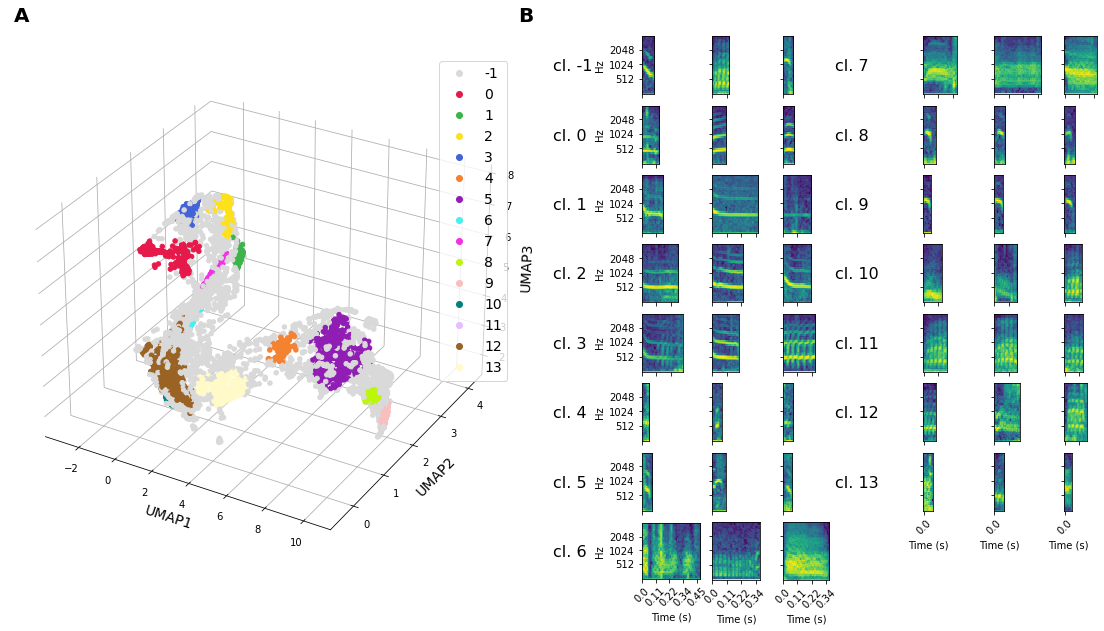

In [157]:
major_tick_interval = 30
f_to_s = 0.00375
rotate_x = 45

plt.figure(figsize=(20,10), facecolor="white")

# 3D scatter plot
ax = plt.subplot(1,2,1, projection='3d')

scat_labels = hdb_labels
mycolors = ['#d9d9d9'] + distinct_colors_22

labeltypes = sorted(list(set(scat_labels)))
pal = sns.color_palette(mycolors, n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]
Axes3D.scatter(ax,
               xs = embedding[:,0],
               ys = embedding[:,1],
               zs = embedding[:,2],
               zdir='z',
               s=20,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1', fontsize=14)
ax.set_ylabel('UMAP2', fontsize=14)
ax.set_zlabel('UMAP3', fontsize=14)
    
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
    
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
ax.legend(scatters, labeltypes, numpoints = 1, fontsize=14)


# Spec examples

cluster_types = sorted(list(set(hdb_labels)))
n_examples = 3
freq_label_list = ['512', '1024', '2048']

nrows = 8
ncols = 16
n_inc = 12
n_start = 9

k=n_start
clustername_dict = dict(zip(cluster_types, ['cl. '+str(x) for x in cluster_types]))

for cl in cluster_types:
    
    # jump to rightmost third of plot when cl. 7
    k=13 if cl==7 else k
    
    # Fake plot with text only
    plt.subplot(nrows, ncols, k)
    plt.axis('off')
    pos = -0.3 if cl<7 else 0
    plt.text(-0.3,0.4, clustername_dict[cl], fontsize=16)
    k=k+1
    
    r=1
    
    # randomly choose examples
    df_subset = df.loc[df.hdb_labels==cl,:]
    examples = df_subset.sample(n=n_examples, random_state=2204)
    specs = examples.spectrograms

    for spec in specs:
        plt.subplot(nrows, ncols, k)
        plt.imshow(spec, interpolation='nearest', origin='lower', aspect=3) 
        
        # Align specs to the left
        ax = plt.gca()
        ax.set_anchor('W')
        
        # Set x and y ticks and labels
        major_xticks = np.arange(0,spec.shape[1], major_tick_interval) 
        major_xtick_labels = ["" for x in major_xticks]
        
        major_yticks = [10,20,30]
        major_ytick_labels = ["" for x in major_yticks]

        # Add y labels for leftmost column of specs
        if r==1 and cl<7:
            major_ytick_labels= freq_label_list
            plt.ylabel('Hz')
            
        # Add x labels for lowest row of specs
        if k>=((nrows-1)*ncols - n_examples):
            major_xtick_labels = [round(x*f_to_s,2) for x in major_xticks]
            plt.xlabel('Time (s)')

        plt.xticks(major_xticks, major_xtick_labels, rotation=rotate_x)
        plt.yticks(major_yticks, major_ytick_labels)
        
        k=k+1
        r=r+1
    k=k+n_inc
    
plt.figtext(0.13,0.9, "A", size=20, weight='bold')
plt.figtext(0.48,0.9, "B", size=20, weight='bold')
plt.savefig(os.path.join(os.path.sep, FIGURES,'paper_cluster_examples.png'), facecolor="white", bbox_inches='tight')

## Figure 2

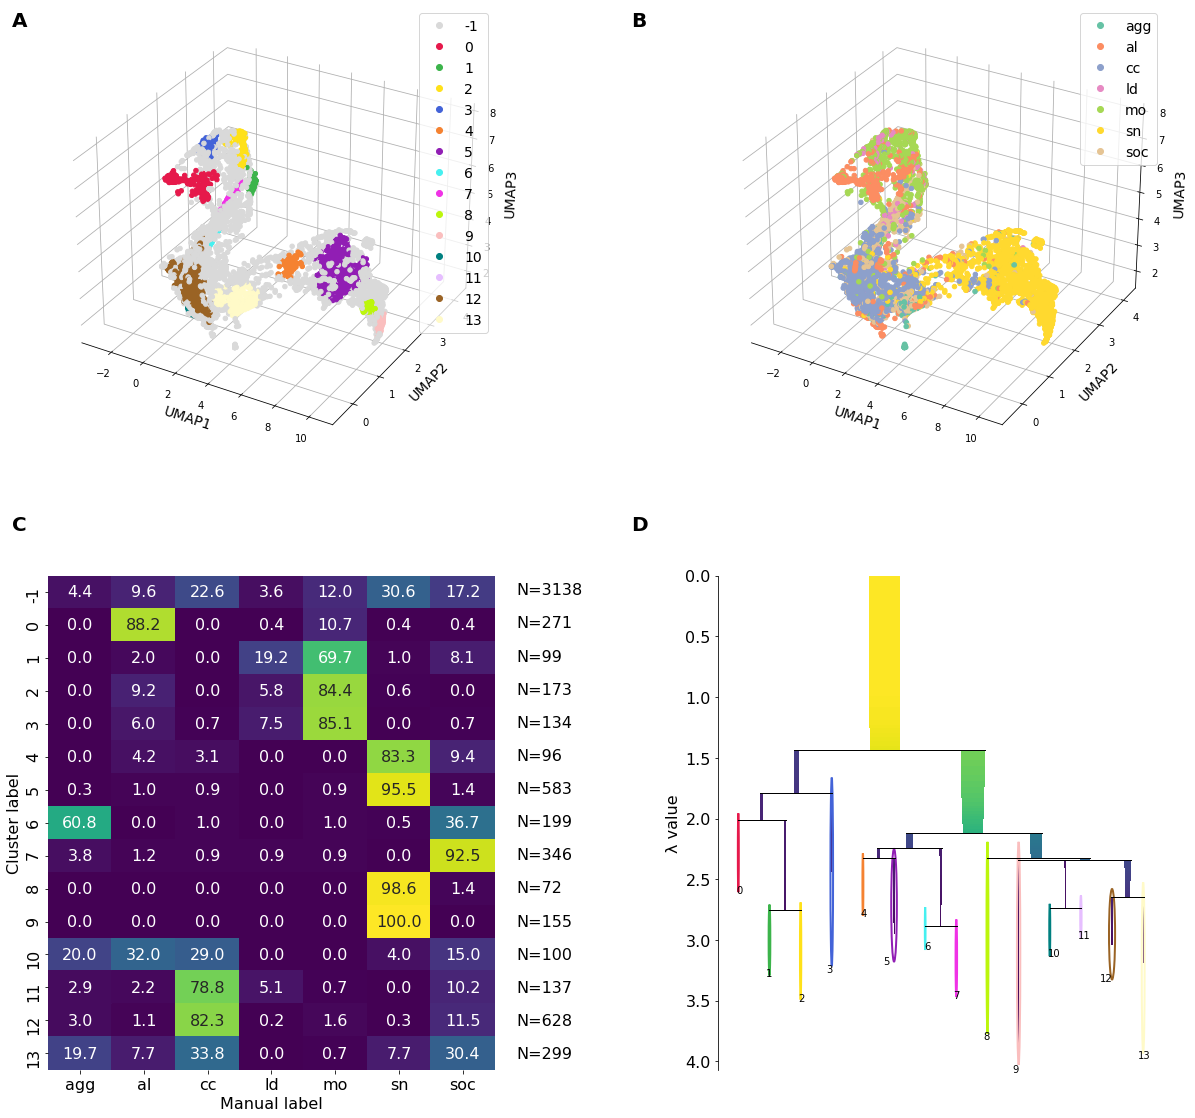

In [102]:
cluster_labels = hdb_labels
truth_var = "call_lable"
plt.figure(figsize=(20,20), facecolor="white")

ax = plt.subplot(2,2,1, projection='3d')

scat_labels = hdb_labels
mycolors = ['#d9d9d9'] + distinct_colors_22

labeltypes = sorted(list(set(scat_labels)))
pal = sns.color_palette(mycolors, n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]
Axes3D.scatter(ax,
               xs = embedding[:,0],
               ys = embedding[:,1],
               zs = embedding[:,2],
               zdir='z',
               s=20,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1', fontsize=14)
ax.set_ylabel('UMAP2', fontsize=14)
ax.set_zlabel('UMAP3', fontsize=14)
    
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
    
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
ax.legend(scatters, labeltypes, numpoints = 1, fontsize=14)

ax = plt.subplot(2,2,2, projection='3d')

scat_labels = df.call_lable.values
mycolors = "Set2"

labeltypes = sorted(list(set(scat_labels)))
pal = sns.color_palette(mycolors, n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]
Axes3D.scatter(ax,
               xs = embedding[:,0],
               ys = embedding[:,1],
               zs = embedding[:,2],
               zdir='z',
               s=20,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1', fontsize=14)
ax.set_ylabel('UMAP2', fontsize=14)
ax.set_zlabel('UMAP3', fontsize=14)
    
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
    
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
ax.legend(scatters, labeltypes, numpoints = 1, fontsize=14)
        

ax = plt.subplot(2,2,3)
# plot cluster content vs. ground truth 
cluster_labeltypes = sorted(list(set(hdb_labels)))
true_labeltypes = sorted(list(set(df.call_lable.values)))
    
stats_tab = np.zeros((len(cluster_labeltypes), len(true_labeltypes)))
for i,clusterlabel in enumerate(cluster_labeltypes):
    label_df = df.loc[cluster_labels==clusterlabel]
    for j, truelabel in enumerate(true_labeltypes):
        stats_tab[i,j] = sum(label_df[truth_var]==truelabel)
    
# rowsums
stats_tab_norm = np.zeros((stats_tab.shape))
rowsums = np.sum(stats_tab, axis=1)
for i in range(stats_tab.shape[0]):
    stats_tab_norm[i,:] = stats_tab[i,:]/rowsums[i]
    
stats_tab = pd.DataFrame(stats_tab, index=cluster_labeltypes, columns=true_labeltypes)
stats_tab_norm = pd.DataFrame(stats_tab_norm, index=cluster_labeltypes, columns=true_labeltypes) * 100
    
ax = sns.heatmap(stats_tab_norm, annot=True, cmap='viridis', fmt='.1f', cbar=False, annot_kws={"size":16})
ax.set_xlabel("Manual label", fontsize=16)
ax.set_ylabel("Cluster label", fontsize=16) 
ax.tick_params(labelsize=16)

ax = plt.subplot(2,2,4)
labeltypes = sorted(list(set(hdb_labels)))
customPalette = sns.color_palette(distinct_colors_22, n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, customPalette))

HDBSCAN.condensed_tree_.plot(select_clusters=True,
                             selection_palette=customPalette,
                             label_clusters = True,
                             colorbar=False,
                            )
ax.set_ylabel("λ value", fontsize=16)
ax.tick_params(labelsize=16)

plt.figtext(0.1,0.85, "A", size=20, weight='bold')
plt.figtext(0.53,0.85, "B", size=20, weight='bold')

plt.figtext(0.1,0.5, "C", size=20, weight='bold')
plt.figtext(0.53,0.5, "D", size=20, weight='bold')


# Add total N per cluster
cluster_N_dict = dict(zip(np.arange(np.min(hdb_labels), np.max(hdb_labels)+1,1), pd.DataFrame(pd.Series(hdb_labels).value_counts()).sort_index()[0].values))

start_pos = 0.455
incr = 0.023
pos = start_pos
for key in cluster_N_dict.keys():
    plt.figtext(0.45,pos, "N="+str(cluster_N_dict[key]), size=16)
    pos = pos - incr
    

plt.subplots_adjust(wspace=0.5)
plt.savefig(os.path.join(os.path.sep, FIGURES, 'paper_cluster_eval.png'), facecolor="white", bbox_inches="tight")

In [63]:
tree = HDBSCAN.condensed_tree_.to_pandas()
tree

parent  child  lambda_val  child_size
0       6430   3986    0.727673           1
1       6430   1813    0.732808           1
2       6430   1825    0.735215           1
3       6430   1814    0.735346           1
4       6430   1815    0.735937           1
...      ...    ...         ...         ...
6451    6455   6138    3.263090           1
6452    6455   6010    3.263090           1
6453    6455   5205    3.263090           1
6454    6455   6278    3.263090           1
6455    6455   4302    3.263090           1

[6456 rows x 4 columns]

# EXTRA: Inspect alarm call clusters

Alarm calls seem to be split into an almost pure alarm cluster 0, and an alarm, cc, agg and soc cluster 10. Since alarm calls are very variable and we didn't differentiate between terrestrial vs. aerial alarm calls etc., it would be interesting to know whether the separation into distinct clusters fits to this known distinction.

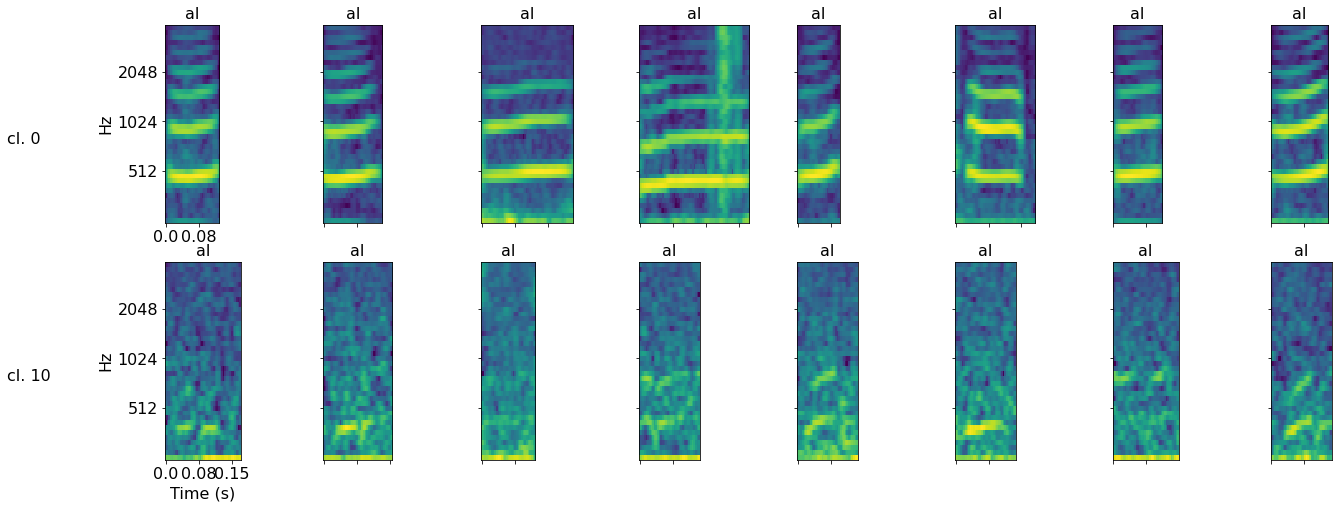

In [51]:
# EXAMPLE ALARM SPECS FOR Cl. 0

freq_label_list = ['512', '1024', '2048']

# only interested in alarm calls here:
sub_df = df.loc[df.call_lable=='al',:]

plt.figure(figsize=(25,8), facecolor="white")
n_examples = 8
ncols = n_examples+1
major_tick_interval = 20
f_to_s = 0.00375
rotate_x = 0

k=1


for cl in [0,10]:
    plt.subplot(2,ncols,k)
    plt.axis('off')
    plt.text(0,0.4, 'cl. '+str(cl), fontsize=16)
    k=k+1
    
    #plt.subplot(2,ncols,k)
    #plt.axis('off')
    #k=k+1
    

    example = sub_df[sub_df['hdb_labels']==cl].sample(n = n_examples, random_state=1234)
    specs = example['spectrograms'].values
    labels = example['call_lable'].values

    for spec, label in zip(specs, labels):
        plt.subplot(2, ncols, k)
        plt.imshow(spec, interpolation='nearest', origin='lower', aspect=3)
        ax = plt.gca()
        ax.set_anchor('W')
        plt.title(label, fontsize=16)
        #plt.axis('off')
        
        major_xticks = np.arange(0,spec.shape[1], major_tick_interval) 
        major_xtick_labels = ["" for x in major_xticks]
        
        major_yticks = [10,20,30]
        major_ytick_labels = ["" for x in major_yticks]
        
        if k==2 or k==ncols+2:     
            major_ytick_labels = freq_label_list
            major_xtick_labels = [round(x*f_to_s,2) for x in major_xticks]
            plt.ylabel('Hz', fontsize=16)
        if k==ncols+2:
            plt.xlabel('Time (s)', fontsize=16)
        
        plt.yticks(major_yticks, major_ytick_labels, fontsize=16)
        plt.xticks(major_xticks, major_xtick_labels, rotation=rotate_x, fontsize=16)
        k += 1

#plt.tight_layout()
plt.savefig(os.path.join(os.path.sep,FIGURES,'alarm_cluster_examples.png'), facecolor="white")

# EXRA_Distribution

#### Categorical variables

Figure that shows frequencies of **categorical** variables in different groups.
Set groups and variable of interest with 
- group_var = [name_of_grouping_variable] 
- var [categorical_variable_of_interest]

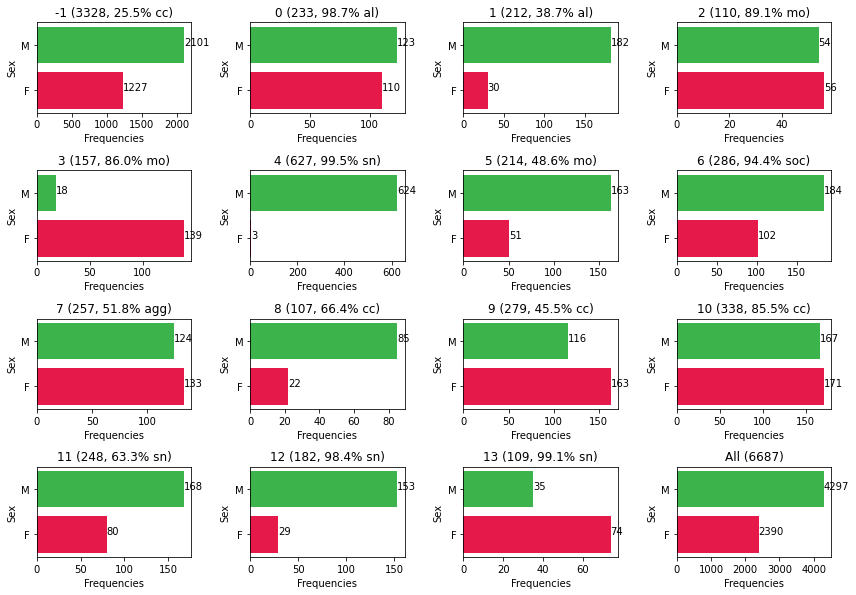

In [ ]:
var = 'status'
var = 'Sex'
#var = 'date'
#var = 'indv'
#var = 'soundfoc_yn'
group_var = 'call_lable'
group_var = 'HDBSCAN'

#var_levels = sorted(list(set(umap_df[var])))
#group_var_levels =  sorted(list(set(umap_df[group_var])))
truth = 'call_lable'

#plt.figure(figsize=(10, 20))
plt.figure(figsize=(12, 10))

my_df = umap_df.loc[umap_df[var]!='NA']
#my_df = my_df.loc[my_df[group_var]!=-1] # for HDBSCAN
var_levels = sorted(list(set(my_df[var])))
group_var_levels =  sorted(list(set(my_df[group_var])))

for i,group_var_level in enumerate(group_var_levels,1):
    #plt.subplot(5, 3, i)
    plt.subplot(5, 4, i)
    sub_df = my_df.loc[my_df[group_var]==group_var_level]

    labelcounts = pd.DataFrame(sub_df[var].value_counts())

    for level in var_levels:
      if (not level in labelcounts.index):
        row = pd.Series({var:0},name=level)
        labelcounts = labelcounts.append(row)


    labelcounts.sort_index(inplace=True)
    pal = sns.color_palette(distinct_20, n_colors=len(labelcounts.index))  
    #pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
    plt.barh(labelcounts.index, labelcounts[var].values, color = pal)

    for index, value in enumerate(labelcounts[var].values):
      plt.text(value, index, str(value))
    title = str(group_var_level)+" ("+str(sub_df.shape[0])+")"
    if group_var!=truth:
      title = str(group_var_level)+" ("+str(sub_df.shape[0])+", "+cluster_to_truth[group_var_level]+")"
    plt.title(title)
    plt.ylabel(var)
    plt.xlabel('Frequencies')

# Add plot for all
#plt.subplot(5, 3, i+1)
plt.subplot(5, 4, i+1)
sub_df = my_df

#labelcounts = pd.DataFrame(sub_df[var].value_counts())
labelcounts = pd.DataFrame(umap_df[var].value_counts())
labelcounts.sort_index(inplace=True)

plt.barh(labelcounts.index, labelcounts[var].values, color = pal)

for index, value in enumerate(labelcounts[var].values):
  plt.text(value, index, str(value))

#title='All ('+str(my_df.shape[0])+")"
title='All ('+str(umap_df.shape[0])+")"
plt.title(title)
plt.ylabel(var)
plt.xlabel('Frequencies')

plt.tight_layout()
plt.savefig(FIGURES+'cluster_analysis_'+group_var+'_'+var+'.png')

In [ ]:
2382/6687

0.35621354867653654

In [ ]:
sorted(list(set(umap_df['date'])))

['2017-08-03',
 '2017-08-06',
 '2017-08-07',
 '2017-08-23',
 '2017-08-24',
 '2017-08-25',
 '2017-09-03',
 '2017-09-04',
 '2017-09-05',
 '2019-07-12',
 '2019-07-13',
 '2019-07-14',
 '2019-07-15',
 '2019-07-16',
 '2019-07-17']

#### Continuous variables

Figure that shows distribution of **continuous** variables in different groups.
Set groups and variable of interest with 
- group_var = [name_of_grouping_variable] 
- var [continuous_variable_of_interest]


In [ ]:
var = 'duration_s'
group_var = 'call_lable'
group_var = 'Aggl_Euclid'

group_var_levels =  sorted(list(set(umap_df[group_var])))

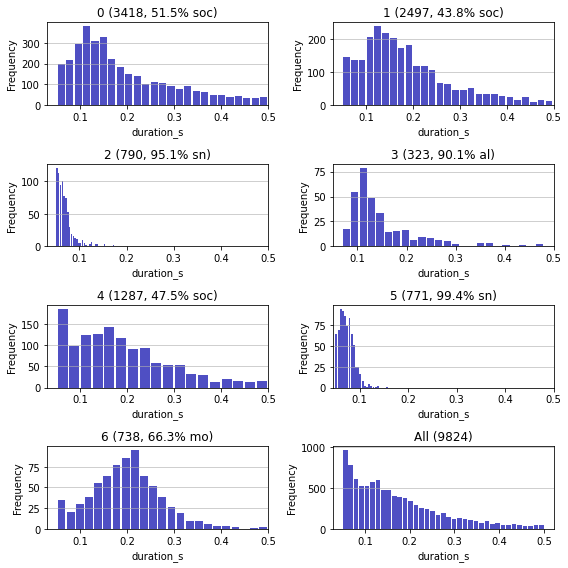

In [ ]:
plt.figure(figsize=(8, 8))

xmax = np.max(umap_df[var].values)

for i,group_var_level in enumerate(group_var_levels,1):
    plt.subplot(4, 2, i)
    sub_df = umap_df.loc[umap_df[group_var]==group_var_level]

    n, bins, patches = plt.hist(x=sub_df[var], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)

    title = str(group_var_level)+" ("+str(sub_df.shape[0])+")"
    if group_var!=truth:
      title = str(group_var_level)+" ("+str(sub_df.shape[0])+", "+cluster_to_truth[group_var_level]+")"
 
    plt.xlim(xmax=xmax)
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xlabel(var)

# Add plot for al
plt.subplot(4, 2, i+1)
sub_df = umap_df

n, bins, patches = plt.hist(x=sub_df[var], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)

title = 'All ('+str(sub_df.shape[0])+")"
plt.title(title)
plt.ylabel('Frequency')
plt.xlabel(var)

plt.tight_layout()

### Overrepresentation

#### Categorical variables

In [ ]:
var = 'status'
#var = 'Sex'
#var = 'soundfoc_yn'
group_var = 'call_lable'
#group_var = 'Aggl_Euclid'
group_var = 'HDBSCAN'
truth = 'call_lable'

In [ ]:
umap_df.head(2)

Name        Start  Duration  ... certain_yn index_id nonfocal_yn
1598  ALARM  1:10:56.215  0:00.178  ...          y     1598           n
1599  ALARM  1:12:04.643  0:00.317  ...          y     1599           n

[2 rows x 35 columns]

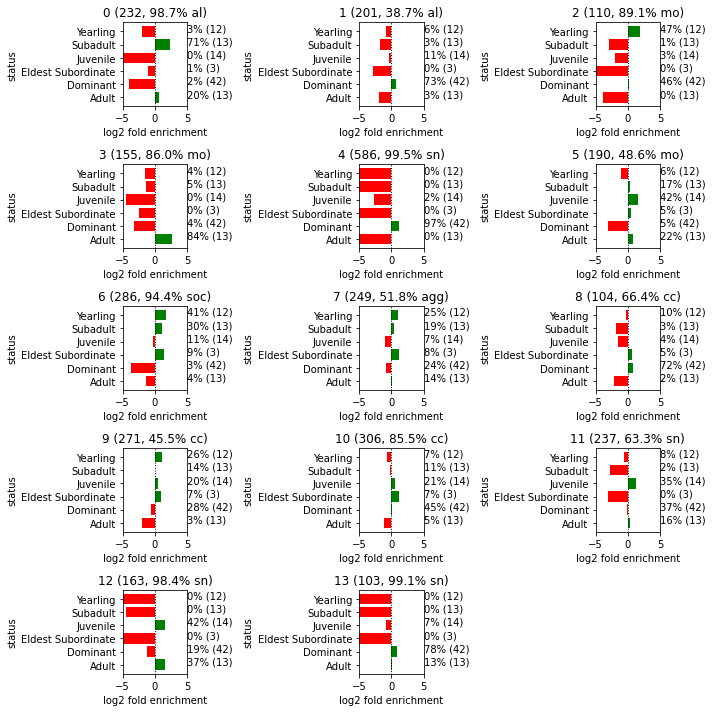

In [ ]:
plt.figure(figsize=(10, 10))

# Remove NA
my_df = umap_df.loc[umap_df[var]!='NA']
my_df = my_df.loc[umap_df[group_var]!=-1]
var_levels = sorted(list(set(my_df[var])))
group_var_levels =  sorted(list(set(my_df[group_var])))

labelcounts_all = pd.DataFrame(my_df[var].value_counts(normalize=True))
labelcounts_all.sort_index(inplace=True)

for i,group_var_level in enumerate(group_var_levels,1):
  plt.subplot(5, 3, i)
  sub_df = my_df.loc[my_df[group_var]==group_var_level]
  

  labelcounts = pd.DataFrame(sub_df[var].value_counts(normalize=True))

  missing_level = []

  for i,level in enumerate(var_levels):
    if (not level in labelcounts.index):
      missing_level.append(True)
      row = pd.Series({var:100/(sub_df.shape[0])},name=level) # equi to 1 meerkat
      row = pd.Series({var:1},name=level)
      labelcounts = labelcounts.append(row)
    else:
      missing_level.append(False)
  
  labelcounts.sort_index(inplace=True)
  #pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
  y = np.log2(labelcounts[var].values/labelcounts_all[var].values)
  # log of 0 problem! thus, set missing levels to % equivalent to 1 meerkat
  
  c = ["red" if x<=0 else "green" for x in y]
  xmin = -5
  xmax = 5
  for i,missing in enumerate(missing_level):
    if(missing):
      c[i] = "red"
      y[i] = xmin
      labelcounts.iloc[i,0] = 0


  plt.barh(labelcounts.index, y, color = c)
  #plt.barh(labelcounts.index, y, color = pal)
  #plt.bar(labelcounts.index, y, color = pal)
  plt.axvline(x=0, color="black", linewidth=1,linestyle=':')


  for index, (value1,value2,y) in enumerate(zip(labelcounts[var].values, labelcounts_all[var].values,y)):
     #plt.text(y, index, (str(round(value1*100,1))+"% ("+str(round(value2*100,1))+"%)"))
     plt.text(xmax, index, (str(int(value1*100))+"% ("+str(int(value2*100))+")"))

  title = str(group_var_level)+" ("+str(sub_df.shape[0])+")"
  if group_var!=truth:
    title = str(group_var_level)+" ("+str(sub_df.shape[0])+", "+cluster_to_truth[group_var_level]+")"
  plt.title(title)
  
  plt.ylabel(var)
  plt.xlabel('log2 fold enrichment')
  plt.xlim(-5,5)

plt.tight_layout()

# Example specs

Example spectrograms for all clusters

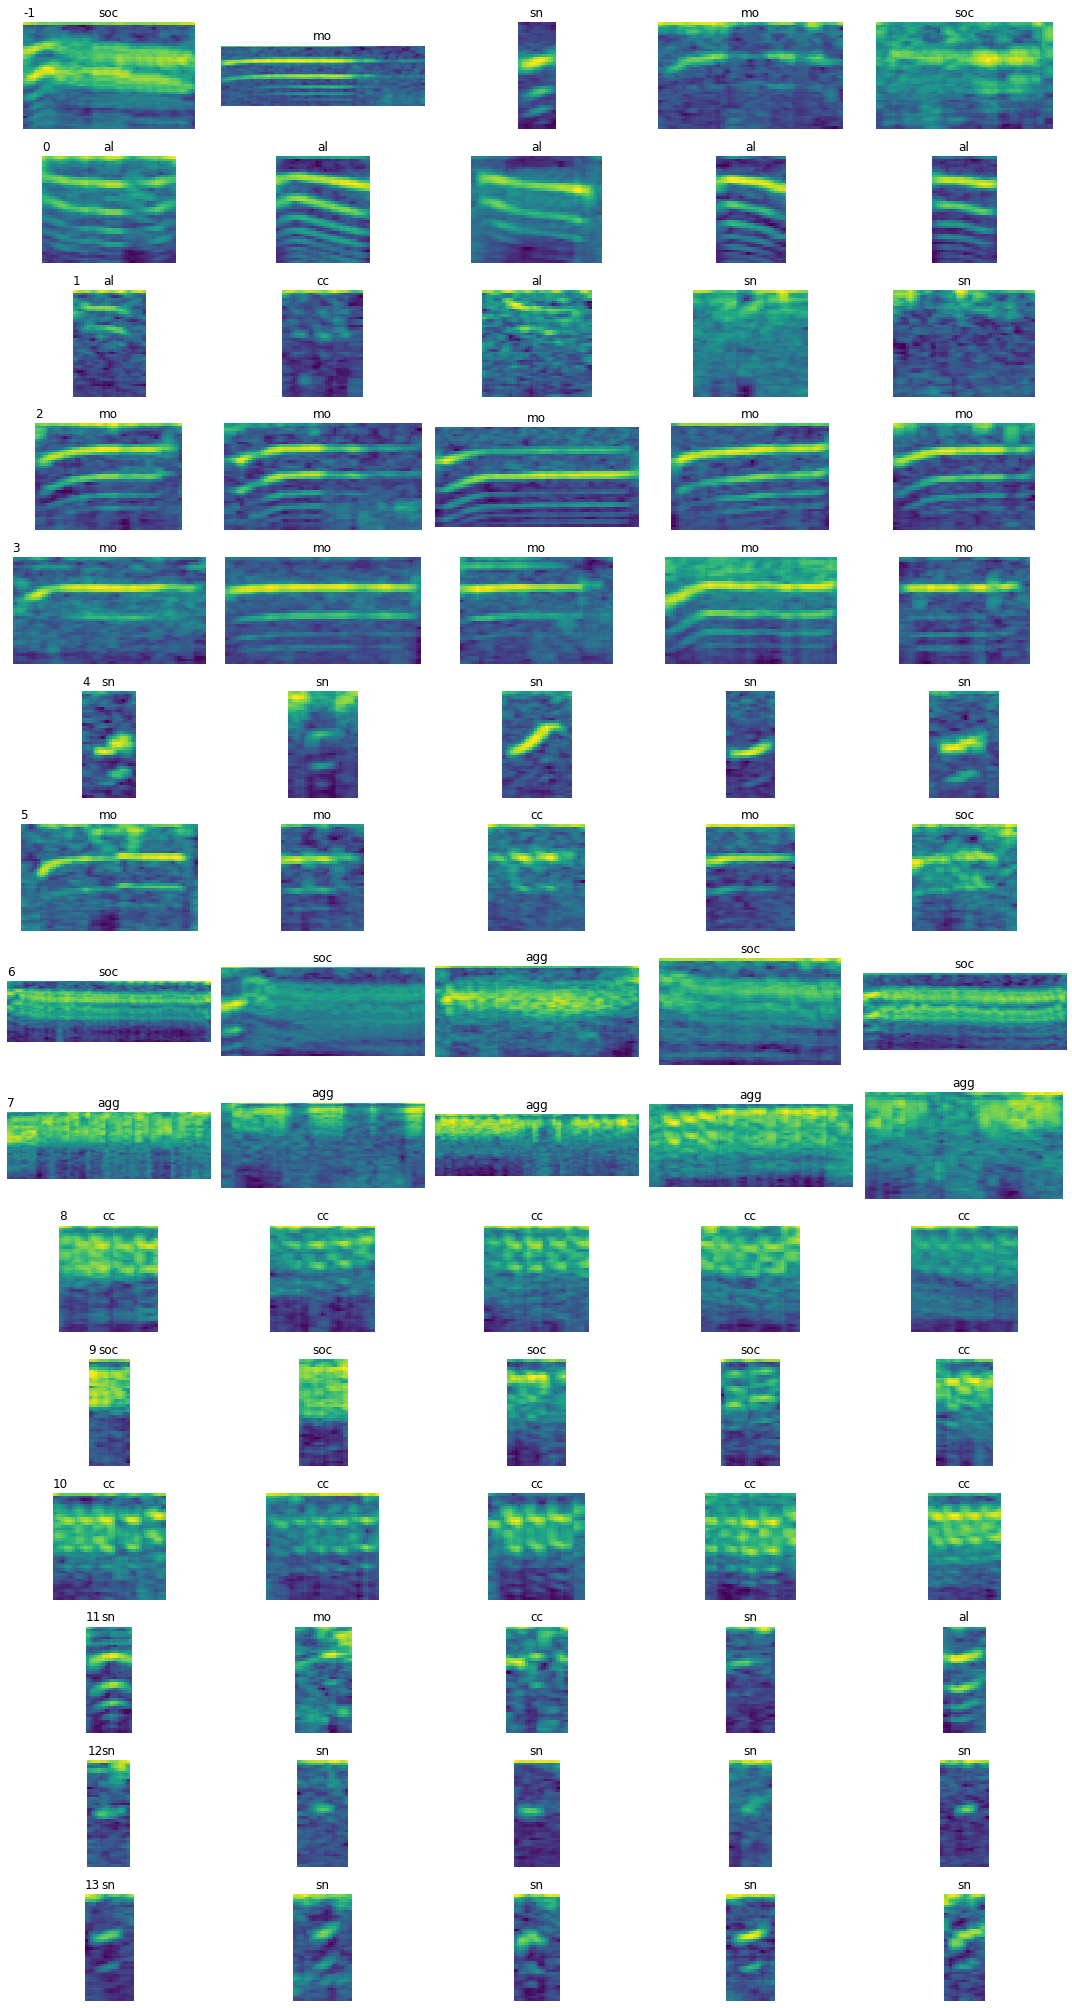

In [ ]:
n_specs=5
specs = {}
  
plt.figure(figsize=(15, 28))

clusters = sorted(list(set(umap_df.HDBSCAN.values)))
k=1

for cluster in clusters:
    example = umap_df[umap_df['HDBSCAN']==cluster].sample(n = n_specs, random_state=2204)
    specs = example['denoised_spectrograms'].values
    labels = example['call_lable'].values
    i=0 
    for spec, label in zip(specs, labels):
        plt.subplot(len(clusters), n_specs, k)
        plt.imshow(spec, interpolation='nearest', aspect='equal', origin='lower')
        plt.axis('off')
        if i==0:     
            title = str(cluster)
            plt.title(title, loc='left')
            title = str(label)
            plt.title(title)
        else:
            title = str(label)
            plt.title(title)
    
    #title = str(cluster)+" ("+str(label)+")"
    #title = str(label)
        k += 1
        i+=1
plt.tight_layout()
plt.savefig(os.path.join(os.path.sep(FIGURES,'HDBSCAN_cluster_examples.png'))